# Import librairies and load Dataset

In [2]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import shutil
from PIL import Image

In [ ]:
# Load Data
folder="/content/drive/MyDrive/Agriculture_project"
csv_data=glob.glob(f"{folder}/*csv")
print(csv_data)

In [4]:
train=pd.read_csv(csv_data[1])
test=pd.read_csv(csv_data[0])
print(train.shape, test.shape)

(1821, 5) (1821, 1)


In [5]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB
None


In [6]:
print(f"Pas de valeurs manquantes,  ")


Pas de valeurs manquantes,  


<Axes: >

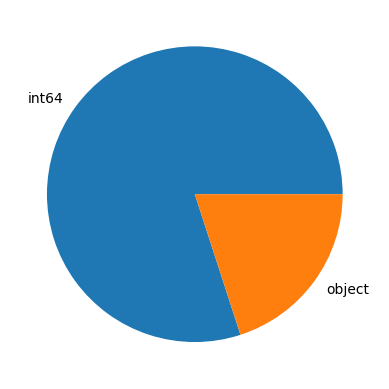

In [7]:
train.dtypes.value_counts().plot(kind="pie")

In [8]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [9]:
train.sample(10)

,image_id,healthy,multiple_diseases,rust,scab
1405,Train_1405,0,0,0,1
1048,Train_1048,0,0,1,0
739,Train_739,0,0,1,0
1172,Train_1172,0,0,0,1
472,Train_472,0,0,1,0
179,Train_179,1,0,0,0
1049,Train_1049,0,0,0,1
1756,Train_1756,0,0,0,1
1305,Train_1305,0,0,0,1
637,Train_637,1,0,0,0


In [10]:
train.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


Pourcentage de chaque target

In [11]:
columns=train.columns[1:]
for col in columns:
  print(f"Pourcentage target {col}={round(train[col].values.sum()*100/train.shape[0],2)} %")

Pourcentage target healthy=28.34 %
Pourcentage target multiple_diseases=5.0 %
Pourcentage target rust=34.16 %
Pourcentage target scab=32.51 %


* Les données ne sont pas équilibrés :le multiple_diseases qui a environ moins de 6 fois de données que les autres colonnes ce qui pourra etre fatal pour le modèle



In [12]:
train["multiple_diseases"].values.sum()

91

# Data Vizualisation

In [1]:
resize=(700, 700)

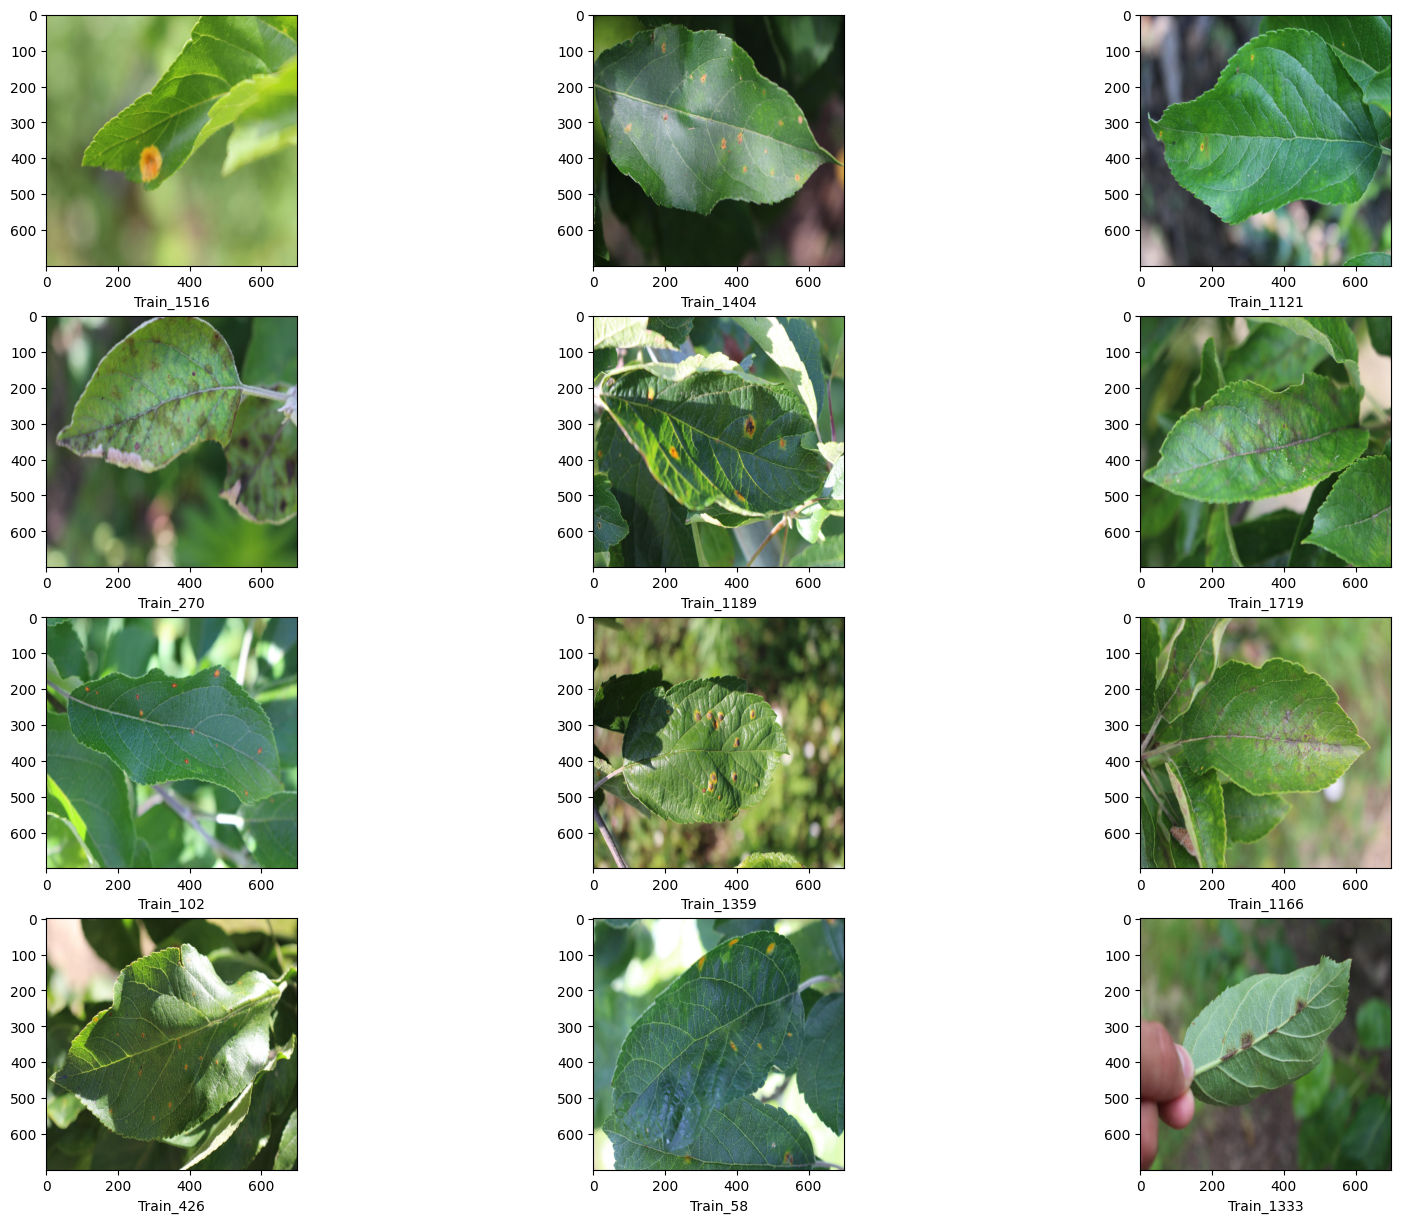

In [13]:
fig=plt.figure(figsize=(20, 15))
for i in range(12):
  plt.subplot(4, 3, i+1)
  p=np.random.choice(train.image_id.values)
  plt.imshow(np.array(Image.open(f"{folder}/images/{p}.jpg").resize(resize)))
  plt.xlabel(p)
plt.show()

# Colect data to text and train

### Colect image to folder

In [14]:
data_dir=f"{folder}/data"
train_dir=f"{data_dir}/train"
test_dir=f"{data_dir}/test"
try:
  os.mkdir(data_dir)
  os.mkdir(train_dir)
  os.mkdir(test_dir)
except:
  pass

In [ ]:
# Train
images=train.image_id.values
for im in images:
  srcfile=f"{folder}/images/{im}/.jpg"
  destfile=srcfile.replace("images", "data/train")
  shutil.copyfile(srcfile, destfile)

In [49]:
# Test
images=test.image_id.values
for im in images:
  srcfile=f"{folder}/images/{im}.jpg"
  destfile=srcfile.replace("images", "data/test")
  shutil.copyfile(srcfile, destfile)



In [32]:
from PIL import Image
last_im=np.array(Image.open("/content/drive/MyDrive/Agriculture_project/images/Test_4.jpg"))
print(last_im.shape)

(1365, 2048, 3)


In [15]:
X_train=[]

resize_shape=700, 700
impath=glob.glob(f"{train_dir}/*.jpg")
for path in impath:
  X_train.append(np.array(Image.open(path).resize(resize_shape)))

X_train=np.array(X_train)
y_train=train.iloc[:, 1:]
print(X_train.shape, y_train.shape)

(1821, 700, 700, 3) (1821, 4)


#Modelisation

In [16]:
input=Input(shape=X_train.shape[1:], name="input")
conv1=Conv2D(128, (3, 3), activation="relu")(input)
conv2=Conv2D(64, (3,3), activation="relu")(conv1)
conv3=Conv2D(32, (3,3), activation='relu')(conv2)
drop=Dropout(0.25)(conv3)
max=MaxPooling2D((2, 2))(drop)
flatten=Flatten()(max)
drop=Dropout(0.25)(flatten)
dense=Dense(64, activation="relu" )(drop)
output=Dense(len(train.columns)-1, activation='softmax' )(dense)


model=Model(inputs=input, outputs=output)

In [17]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["sparse_categorical_accuracy"])

In [ ]:
model.summary()

# Entrainement du Model

In [ ]:
history=model.fit(X_train, y_train, verbose=2, epochs= 100, batch_size=32, validation_split=0.12)

In [ ]:
curve=history.history
loss=curve["loss"]
acc=curve["sparse_categorical_accuracy"]
val_loss=curve['val_loss']
val_acc=curve['val_sparse_categorical_accuracy']
plt.subplot(2, 2, 1)
plt.plot(loss)
plt.xlabel("loss")
plt.legend()
plt.plot(acc)
plt.xlabel("accuracy")


plt.subplot(2, 2, 2)
plt.plot(val_loss)
plt.xlabel("val_loss")
plt.legend()
plt.plot(val_acc)
plt.xlabel("val_accuracy")



plt.show()

# Inférence: Evaluation du Model, Prediction naive, Prédiction réelle

In [ ]:
# Test

X_test=[]

resize_shape=700, 700
impath=glob.glob(f"{test_dir}/*.jpg")
for path in impath:
  X_train.append(np.array(Image.open(path).resize(resize_shape)))

X_test=np.array(X_test)
print(X_test.shape)

### Evaluation du model

In [ ]:
test_predict=model.predict(X_test)
test_predict

In [ ]:
test=test.iloc[:, -1]
test[list(train.columns[1:])]=test_predict
test.to_csv("submission.csv", index=False)

In [ ]:
model.predict(X_test[0:1])

### Prediction Naive

In [ ]:
images_naive=np.ones(X_train[0].shape)
images_naive=images_naive.reshape(1, 32, 32, 3)
classes=list(train.columns[1:])
print(f"La classe prédite est : {classes[np.argmax(model.predict(images_naive))]}")

### Prediction à partir d'une image réelle

In [ ]:
image=Image.open("/content/plant.jpeg")
print(image.format, image.size, image.mode)
print(X_test[0:1].shape)

JPEG (284, 177) RGB
(1, 32, 32, 3)


In [ ]:
image=image.resize(resize)
image=np.asarray(image)
print(image.shape)

(32, 32, 3)


In [ ]:
sh=image.shape
image=image.reshape(1, sh[0], sh[1], sh[2])
print(image.shape)

(1, 32, 32, 3)


In [ ]:
print(f"La classe prédite est : {classes[np.argmax(model.predict(image))]}")

1/1 [==============================] - 0s 103ms/step
La classe prédite est : cars


# Sauvegarde du Model

In [ ]:
model.save("model_plant_pathology.h5")